# 1) IMPORTING LIBRARIES AND PACKAGES

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import pickle
from sklearn import model_selection
# from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
# from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from xgboost import XGBClassifier, XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score,r2_score,mean_absolute_error,mean_squared_error,accuracy_score,classification_report,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import shap
from sklearn.neural_network import MLPRegressor
import model_utils

# 2) DATASET IMPORTING

In [3]:
data = pd.read_csv('Data/DataCoSupplyChainDataset.csv',header= 0,encoding='unicode_escape')
pd.set_option('display.max_columns',None)
data.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,Customer Country,Customer Email,Customer Fname,Customer Id,Customer Lname,Customer Password,Customer Segment,Customer State,Customer Street,Customer Zipcode,Department Id,Department Name,Latitude,Longitude,Market,Order City,Order Country,Order Customer Id,order date (DateOrders),Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Cally,20755,Holloway,XXXXXXXXX,Consumer,PR,5365 Noble Nectar Island,725.0,2,Fitness,18.251453,-66.037056,Pacific Asia,Bekasi,Indonesia,20755,1/31/2018 22:56,77202,1360,13.110000,0.04,180517,327.75,0.29,1,327.75,314.640015,91.250000,Southeast Asia,Java Occidental,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Irene,19492,Luna,XXXXXXXXX,Consumer,PR,2679 Rustic Loop,725.0,2,Fitness,18.279451,-66.037064,Pacific Asia,Bikaner,India,19492,1/13/2018 12:27,75939,1360,16.389999,0.05,179254,327.75,-0.80,1,327.75,311.359985,-249.089996,South Asia,Rajastán,PENDING,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,EE. UU.,XXXXXXXXX,Gillian,19491,Maldonado,XXXXXXXXX,Consumer,CA,8510 Round Bear Gate,95125.0,2,Fitness,37.292233,-121.881279,Pacific Asia,Bikaner,India,19491,1/13/2018 12:06,75938,1360,18.030001,0.06,179253,327.75,-0.80,1,327.75,309.720001,-247.779999,South Asia,Rajastán,CLOSED,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,EE. UU.,XXXXXXXXX,Tana,19490,Tate,XXXXXXXXX,Home Office,CA,3200 Amber Bend,90027.0,2,Fitness,34.125946,-118.291016,Pacific Asia,Townsville,Australia,19490,1/13/2018 11:45,75937,1360,22.940001,0.07,179252,327.75,0.08,1,327.75,304.809998,22.860001,Oceania,Queensland,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Orli,19489,Hendricks,XXXXXXXXX,Corporate,PR,8671 Iron Anchor Corners,725.0,2,Fitness,18.253769,-66.037048,Pacific Asia,Townsville,Australia,19489,1/13/2018 11:24,75936,1360,29.500000,0.09,179251,327.75,0.45,1,327.75,298.250000,134.210007,Oceania,Queensland,PENDING_PAYMENT,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


# 3) EDA (low-level)

In [4]:
filtered_df = data[data['Order Status'].isin(['CANCELED', 'SUSPECTED_FRAUD'])]

# Get the unique values in the 'late delivery risk' column
unique_late_delivery_risks = filtered_df['Late_delivery_risk'].unique()

# Print the unique values
print(unique_late_delivery_risks)

# Canceled and suspected fraud orders are always non-late deliveries, so not useful for the model

[0]


In [5]:
# CHECK IF EVERY ORDER ID HAS SAME ORDER STATUS
grouped_order = data.groupby('Order Id')
print(len(grouped_order))
grouped = data.groupby('Order Id')['Order Status'].nunique()

# Check if each order_id has only one unique 'order_status'
print(grouped == 1)
print(len(grouped == 1))
print(len(grouped))

65752
Order Id
1        True
2        True
4        True
5        True
7        True
         ... 
77200    True
77201    True
77202    True
77203    True
77204    True
Name: Order Status, Length: 65752, dtype: bool
65752
65752


Conclusion: every row represents an ordered item delivery, which can be part of an order delivery. Please note that every order item (=row) belonging to the same order (same order id) has the same order status every time. Thus, for our ML tasks, we will construct one row for each order, containing the information of the customer, the delivery..., and the products belonging to that order (instead of having one row per product as in the original data).

In [6]:
def data_info(data):
    print('1) Number of columns are : ',data.shape[1])
    print('2) Number of rows are : ',data.shape[0])
    print('3) Total number of data-points :',data.size)
    numerical_features = [f for f in data.columns if data[f].dtypes!='O']
    print('4) Count of Numerical Features :',len(numerical_features))
    cat_features = [c for c in data.columns if data[c].dtypes=='O']
    print('5) Count of Categorical Features :',len(cat_features))
data_info(data)

1) Number of columns are :  53
2) Number of rows are :  180519
3) Total number of data-points : 9567507
4) Count of Numerical Features : 29
5) Count of Categorical Features : 24


In [7]:
def features_with_missing_values(data):
    x = data.isnull().sum().sum()/(data.shape[0]*data.shape[1])*100
    print('Percentage of Total Missing Values is ' ,round(x,2) ,'%')
    print('Missing Value Estimation :')
    for i in data.columns:
        if data[i].isna().sum()>0:
            print('The Feature ',i,' has '+ str(data[i].isna().sum()) + ' missing values')
            
features_with_missing_values(data)
# no useful features with missing values

Percentage of Total Missing Values is  3.51 %
Missing Value Estimation :
The Feature  Customer Lname  has 8 missing values
The Feature  Customer Zipcode  has 3 missing values
The Feature  Order Zipcode  has 155679 missing values
The Feature  Product Description  has 180519 missing values


# 4) FEATURE ENGINEERING

In [8]:
#Converting categorical features that represent date and time to datetime datatype.
data['order_date'] = pd.to_datetime(data['order date (DateOrders)'])

In [9]:
# Handling Time and date variables
data['order_year'] = pd.DatetimeIndex(data['order_date']).year
data['order_month'] = pd.DatetimeIndex(data['order_date']).month
data['order_day'] = pd.DatetimeIndex(data['order_date']).day

In [10]:
# Check percentage late_delivery_risk vs non_late_delivery_risk
late_delivery_risk = data['Late_delivery_risk'].value_counts()
print(late_delivery_risk)
print('Percentage of Late Delivery Risk :',round(late_delivery_risk[1]/data.shape[0]*100,2))
perc_late_delivery_risk = round(late_delivery_risk[1]/data.shape[0]*100,2)

Late_delivery_risk
1    98977
0    81542
Name: count, dtype: int64
Percentage of Late Delivery Risk : 54.83


Index(['Type', 'Delivery Status', 'Category Name', 'Customer City',
       'Customer Country', 'Customer Email', 'Customer Fname',
       'Customer Lname', 'Customer Password', 'Customer Segment',
       'Customer State', 'Customer Street', 'Department Name', 'Market',
       'Order City', 'Order Country', 'order date (DateOrders)',
       'Order Region', 'Order State', 'Order Status', 'Product Image',
       'Product Name', 'shipping date (DateOrders)', 'Shipping Mode'],
      dtype='object')
Late_delivery_risk          0          1
Type                                    
CASH                43.367659  56.632341
DEBIT               42.782308  57.217692
PAYMENT             42.470941  57.529059
TRANSFER            51.456408  48.543592


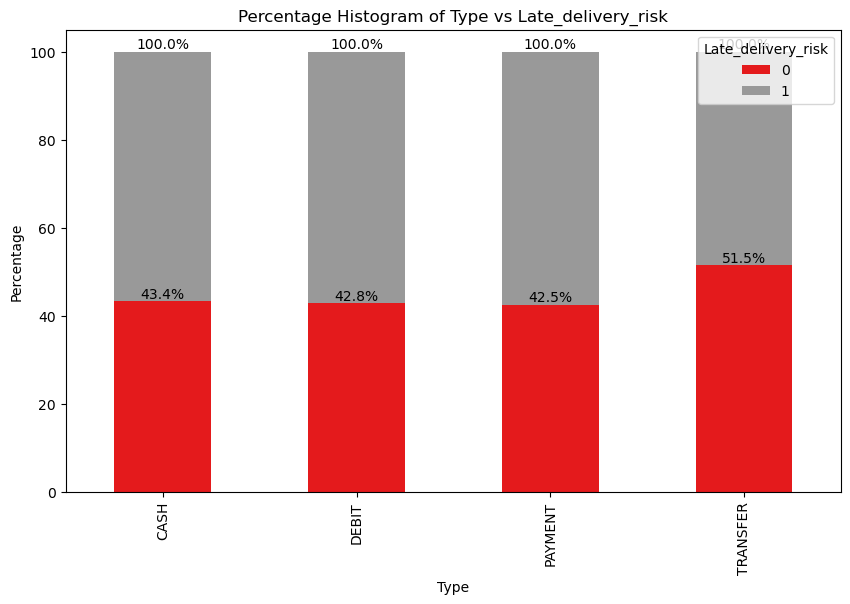

Late_delivery_risk            0          1
Category Name                             
Accessories           43.033708  56.966292
As Seen on  TV!       42.647059  57.352941
Baby                  47.342995  52.657005
Baseball & Softball   44.778481  55.221519
Basketball            44.776119  55.223881
Books                 43.456790  56.543210
Boxing & MMA          43.735225  56.264775
CDs                   47.970480  52.029520
Cameras               41.891892  58.108108
Camping & Hiking      45.465802  54.534198
Cardio Equipment      45.503323  54.496677
Children's Clothing   46.625767  53.374233
Cleats                45.028716  54.971284
Computers             49.321267  50.678733
Consumer Electronics  44.779582  55.220418
Crafts                44.008264  55.991736
DVDs                  46.376812  53.623188
Electronics           43.916350  56.083650
Fishing               45.073593  54.926407
Fitness Accessories   43.042071  56.957929
Garden                44.214876  55.785124
Girls' Appa

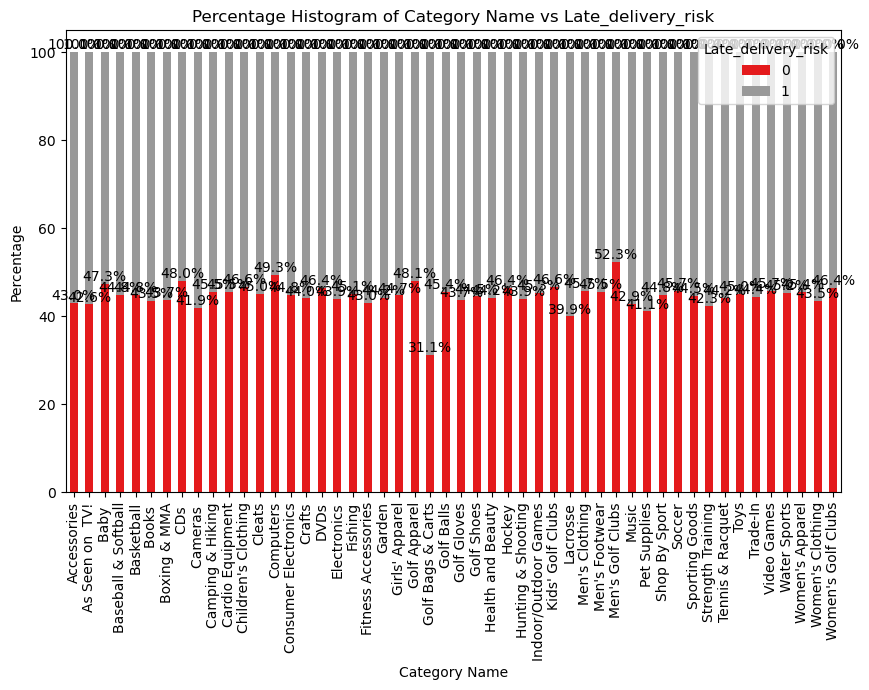

Late_delivery_risk          0          1
Customer Country                        
EE. UU.             45.129829  54.870171
Puerto Rico         45.236619  54.763381


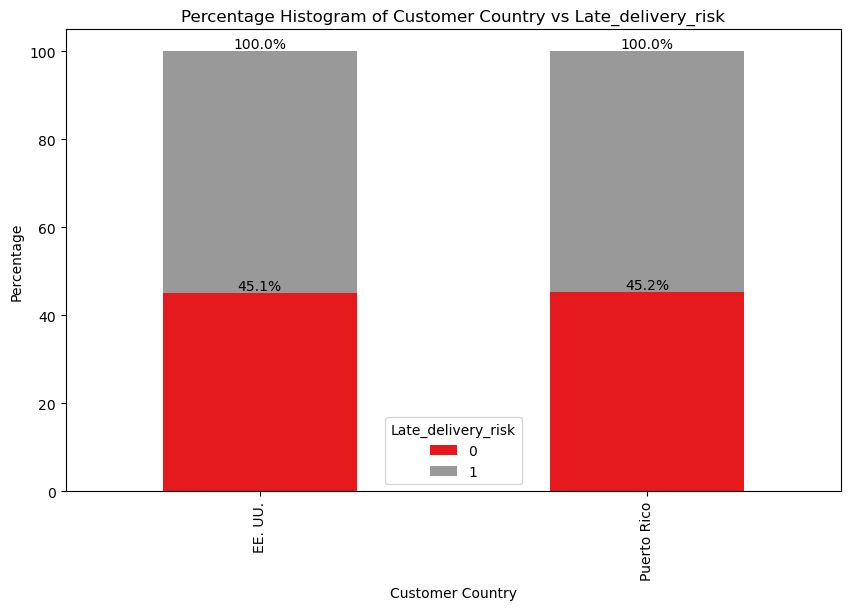

Late_delivery_risk          0          1
Customer Segment                        
Consumer            45.191650  54.808350
Corporate           45.277337  54.722663
Home Office         44.929560  55.070440


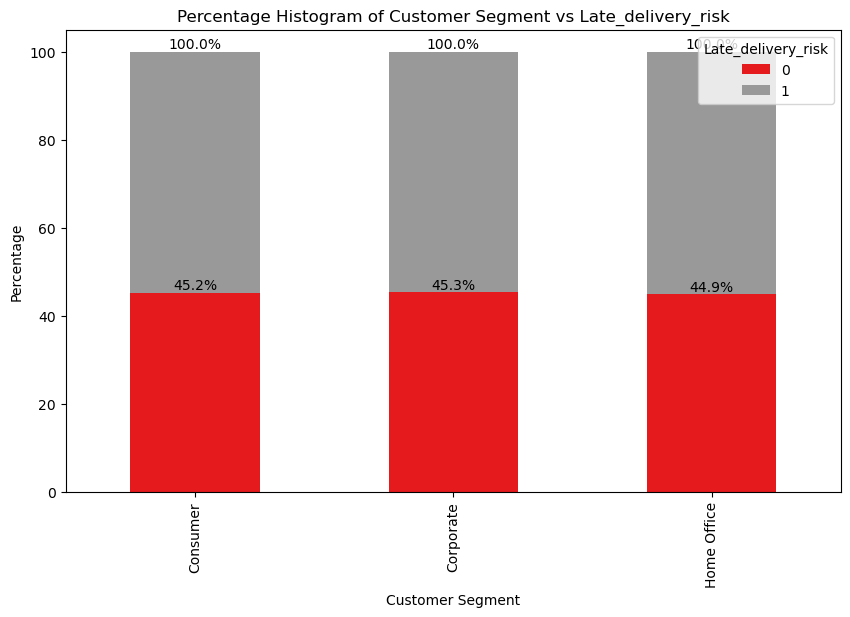

Late_delivery_risk           0          1
Customer State                           
91732               100.000000   0.000000
95758                50.000000  50.000000
AL                   51.428571  48.571429
AR                   42.073171  57.926829
AZ                   48.050231  51.949769
CA                   44.632652  55.367348
CO                   49.320794  50.679206
CT                   44.424132  55.575868
DC                   42.141623  57.858377
DE                   39.776952  60.223048
FL                   46.077713  53.922287
GA                   43.467839  56.532161
HI                   45.833333  54.166667
IA                   44.776119  55.223881
ID                   48.502994  51.497006
IL                   43.611584  56.388416
IN                   43.889845  56.110155
KS                   46.288210  53.711790
KY                   44.353183  55.646817
LA                   47.257384  52.742616
MA                   44.928438  55.071562
MD                   43.064182  56

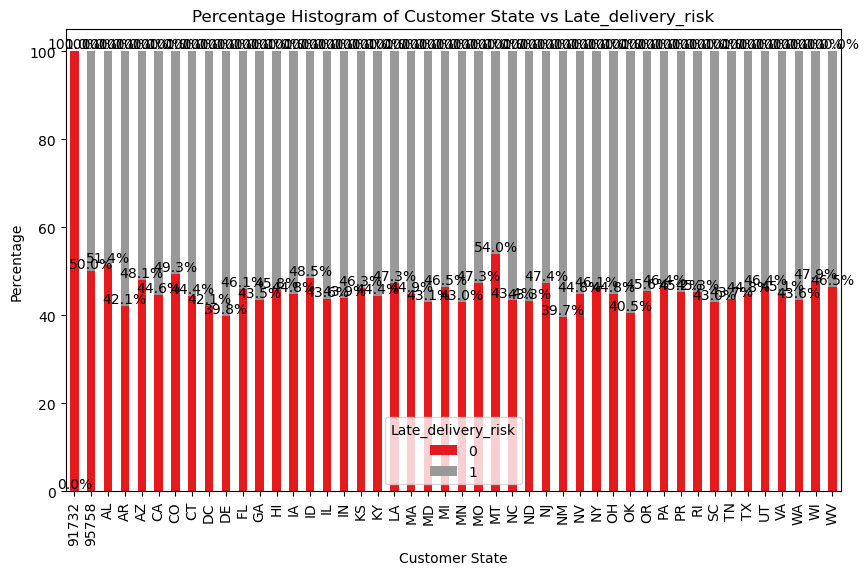

Late_delivery_risk          0          1
Department Name                         
Apparel             45.252867  54.747133
Book Shop           43.456790  56.543210
Discs Shop          45.557749  54.442251
Fan Shop            45.225169  54.774831
Fitness             44.453409  55.546591
Footwear            45.273666  54.726334
Golf                45.219747  54.780253
Health and Beauty   44.198895  55.801105
Outdoors            44.507537  55.492463
Pet Shop            41.056911  58.943089
Technology          44.982935  55.017065


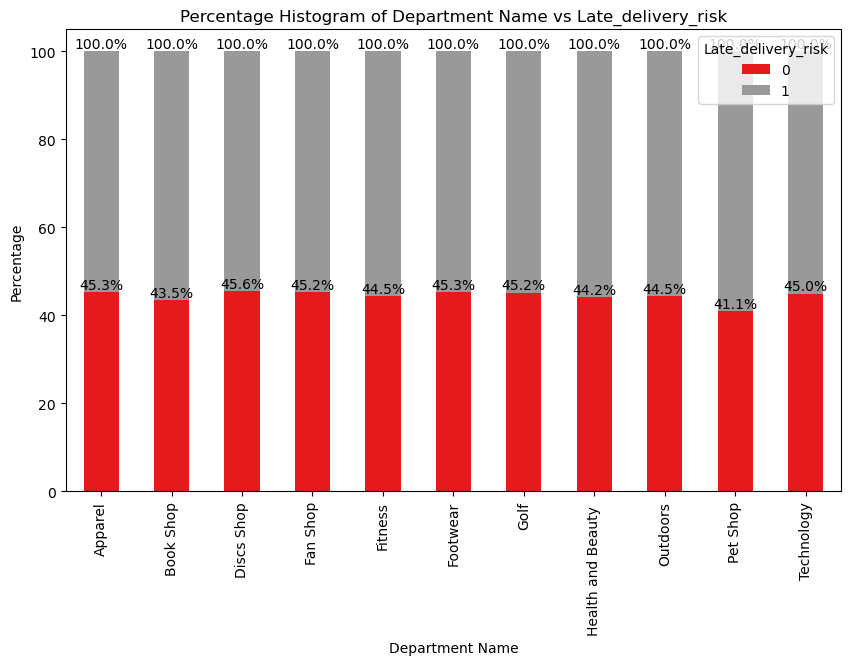

Late_delivery_risk          0          1
Market                                  
Africa              45.410711  54.589289
Europe              44.792247  55.207753
LATAM               45.644842  54.355158
Pacific Asia        44.953951  55.046049
USCA                45.199426  54.800574


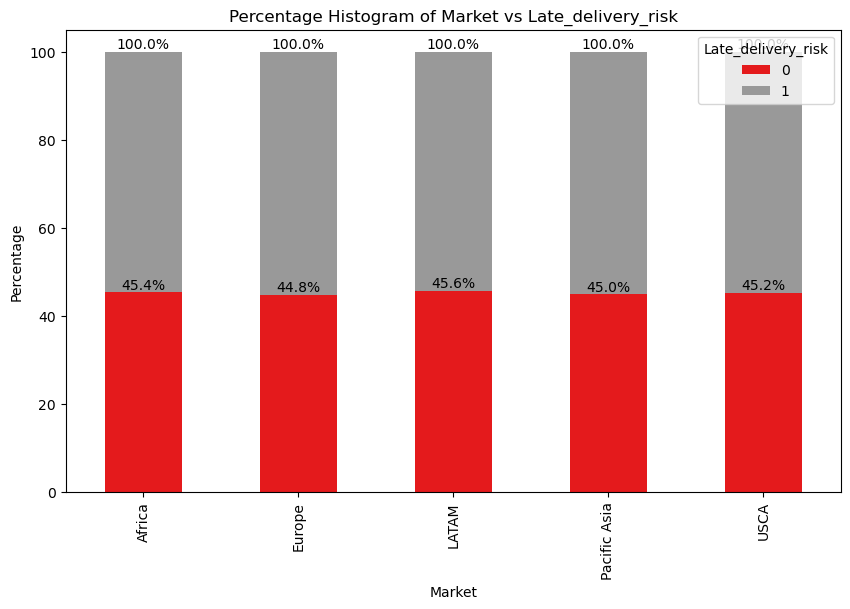

Late_delivery_risk          0          1
Order Country                           
Afganistán          42.944785  57.055215
Albania             40.540541  59.459459
Alemania            43.716018  56.283982
Angola              40.196078  59.803922
Arabia Saudí        42.325581  57.674419
...                       ...        ...
Vietnam             47.952444  52.047556
Yemen               40.845070  59.154930
Yibuti              32.258065  67.741935
Zambia              43.984962  56.015038
Zimbabue            44.210526  55.789474

[164 rows x 2 columns]


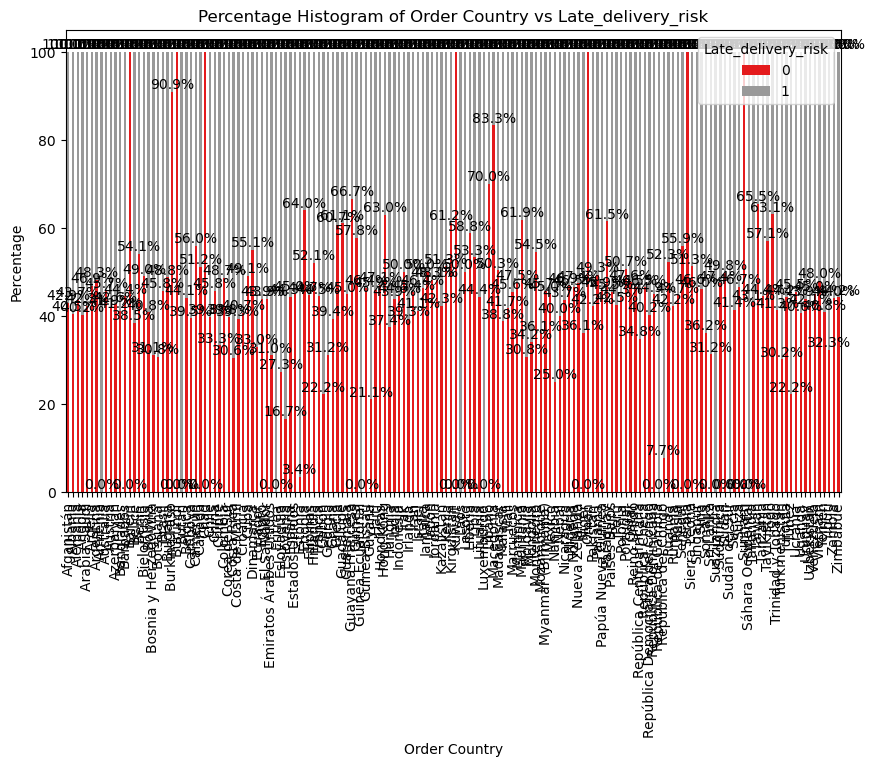

Late_delivery_risk          0          1
Order Region                            
Canada              51.199166  48.800834
Caribbean           46.922337  53.077663
Central Africa      42.039356  57.960644
Central America     45.245404  54.754596
Central Asia        44.665461  55.334539
East Africa         44.060475  55.939525
East of USA         44.338395  55.661605
Eastern Asia        45.673077  54.326923
Eastern Europe      44.336735  55.663265
North Africa        45.482673  54.517327
Northern Europe     45.955882  54.044118
Oceania             45.979503  54.020497
South America       45.691329  54.308671
South Asia          43.733023  56.266977
South of  USA       44.227441  55.772559
Southeast Asia      44.470070  55.529930
Southern Africa     46.672429  53.327571
Southern Europe     45.615523  54.384477
US Center           44.759640  55.240360
West Africa         47.159091  52.840909
West Asia           44.716259  55.283741
West of USA         46.040285  53.959715
Western Europe  

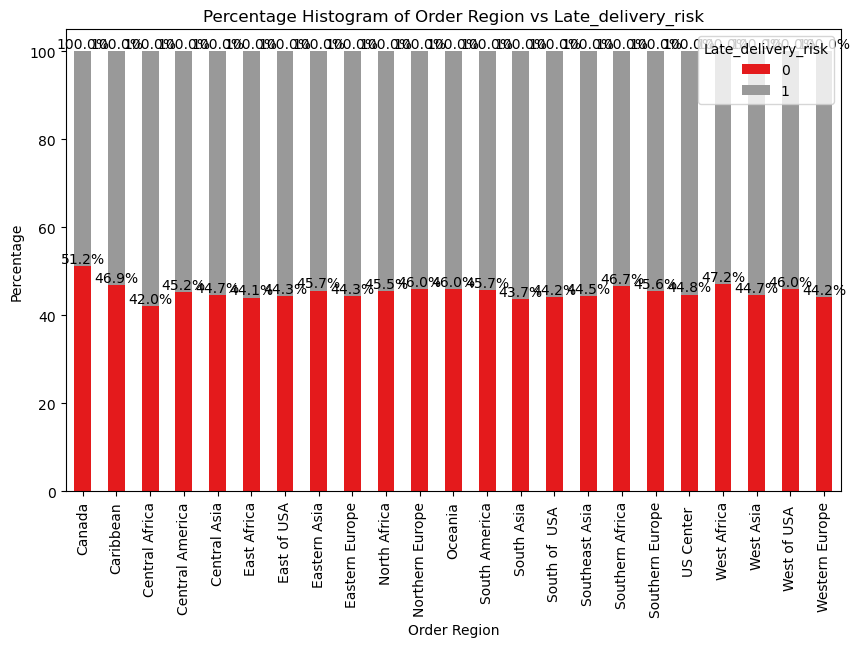

Late_delivery_risk                                     0          1
Product Name                                                       
Adult dog supplies                             41.056911  58.943089
Baby sweater                                   47.342995  52.657005
Bag Boy Beverage Holder                        44.444444  55.555556
Bag Boy M330 Push Cart                         44.927536  55.072464
Bowflex SelectTech 1090 Dumbbells              40.000000  60.000000
...                                                  ...        ...
adidas Kids' F5 Messi FG Soccer Cleat          40.839695  59.160305
adidas Men's F10 Messi TRX FG Soccer Cleat     48.196721  51.803279
adidas Men's Germany Black Crest Away Tee      39.100346  60.899654
adidas Youth Germany Black/Red Away Match Soc  48.407643  51.592357
insta-bed Neverflat Air Mattress               50.000000  50.000000

[118 rows x 2 columns]


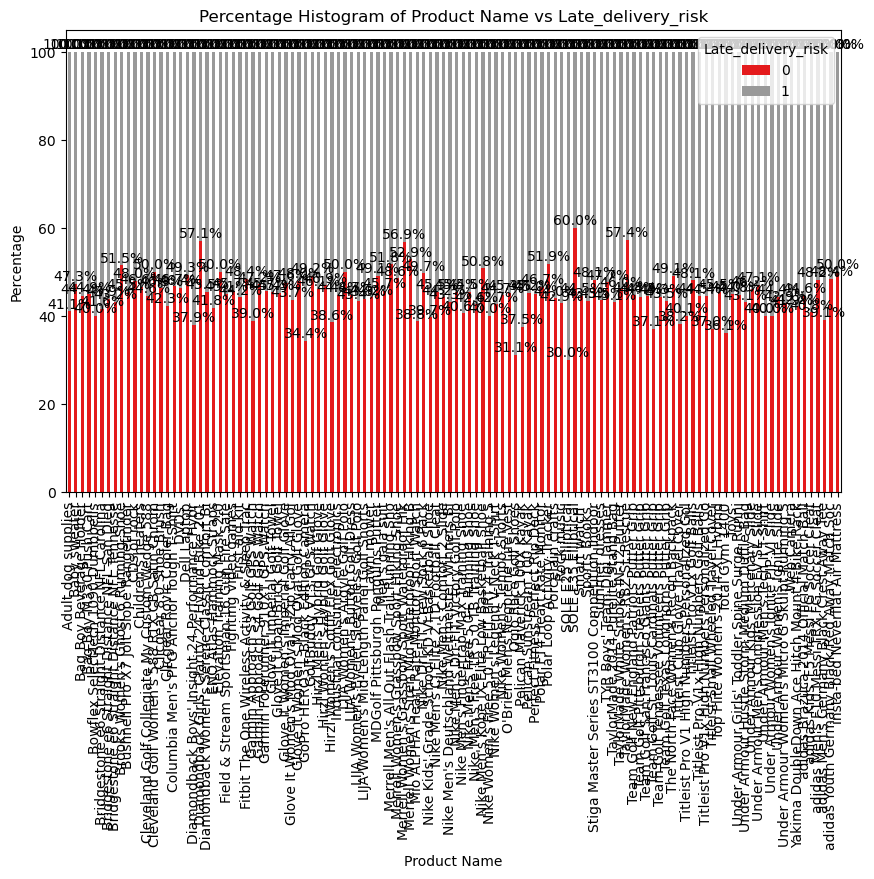

{'Type': ['CASH', 'DEBIT', 'PAYMENT', 'TRANSFER'], 'Customer Country': ['EE. UU.', 'Puerto Rico'], 'Customer Segment': ['Consumer', 'Corporate', 'Home Office'], 'Customer State': ['91732'], 'Market': ['Africa', 'Europe', 'LATAM', 'Pacific Asia', 'USCA'], 'Order Country': ['Armenia', 'Baréin', 'Burkina Faso', 'Burundi', 'Bután', 'Chad', 'Eritrea', 'Eslovenia', 'Estonia', 'Gabón', 'Guayana Francesa', 'Guinea Ecuatorial', 'Guyana', 'Kuwait', 'Laos', 'Luxemburgo', 'Líbano', 'Macedonia', 'Namibia', 'Omán', 'República de Gambia', 'República del Congo', 'Serbia', 'Suazilandia', 'Sudán del Sur', 'Surinam', 'Sáhara Occidental', 'Taiwán', 'Túnez']}


In [11]:
categorical_columns = data.select_dtypes(include=['object', 'category']).columns
print(categorical_columns)

# Drop the columns that are not useful for the model
categorical_columns = categorical_columns.drop([
    'Customer Email', 'Customer Fname', 'Customer Lname', 'Customer Password', 'Customer Street',
    'Product Image', 'order date (DateOrders)', 'shipping date (DateOrders)', 'Order City', 'Order State','Customer City', 'Delivery Status',
    'Order Status', 'Shipping Mode'
])

# Store the column names and value if the late delivery risk percentage differs greatly from the overall percentage
columns_to_analyze = {}

for col in categorical_columns:
    plt.figure(figsize=(10, 6))
    
    # Calculate percentages
    category_counts = data.groupby([col, "Late_delivery_risk"]).size().unstack(fill_value=0)
    category_percentages = category_counts.div(category_counts.sum(axis=1), axis=0) * 100

    # Check whether some values have a percentage of late delivery risk that is significantly different from the overall percentage
    for category in category_percentages.index:
        # Adjust the tolerance based on the amount of categorical values
        if len(category_percentages.index) < 10:
            tolerance = 0
        else:
            tolerance = 20
        if abs(category_percentages.loc[category, 1] - perc_late_delivery_risk) > tolerance:
            if not col in columns_to_analyze:
                columns_to_analyze[col] = []
            columns_to_analyze[col].append(category)
        
    # Plot the percentages
    print(category_percentages)
    category_percentages.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='Set1')
    
    # Annotate the bars with percentages
    for container in plt.gca().containers:
        plt.gca().bar_label(container, fmt='%.1f%%')
    
    plt.title(f'Percentage Histogram of {col} vs Late_delivery_risk')
    plt.ylabel('Percentage')
    plt.xlabel(col)
    plt.legend(title='Late_delivery_risk')
    plt.show()

print(columns_to_analyze)

Index(['Benefit per order', 'Category Id', 'Customer Id', 'Customer Zipcode',
       'Days for shipment (scheduled)', 'Days for shipping (real)',
       'Department Id', 'Latitude', 'Longitude', 'Order Customer Id',
       'Order Id', 'Order Item Cardprod Id', 'Order Item Discount',
       'Order Item Discount Rate', 'Order Item Id', 'Order Item Product Price',
       'Order Item Profit Ratio', 'Order Item Quantity', 'Order Item Total',
       'Order Profit Per Order', 'Order Zipcode', 'Product Card Id',
       'Product Category Id', 'Product Description', 'Product Price',
       'Product Status', 'Sales', 'Sales per customer', 'order_day',
       'order_month', 'order_year'],
      dtype='object')


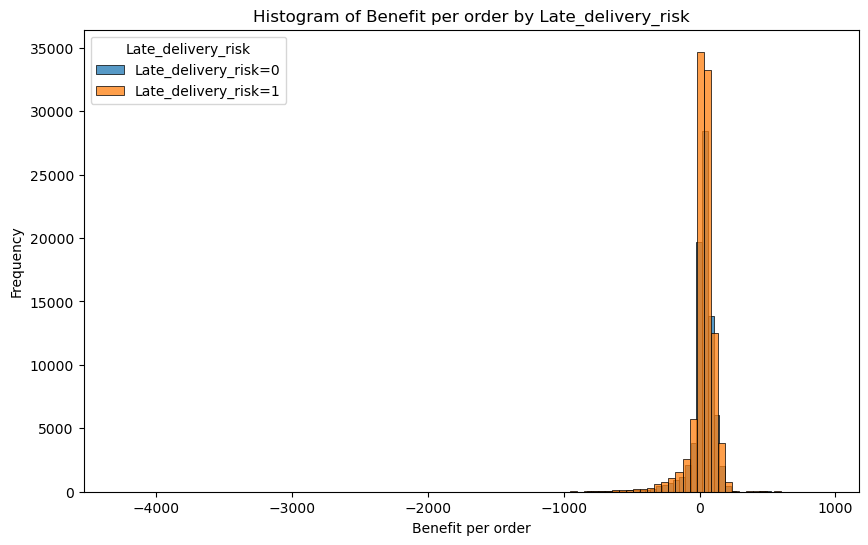

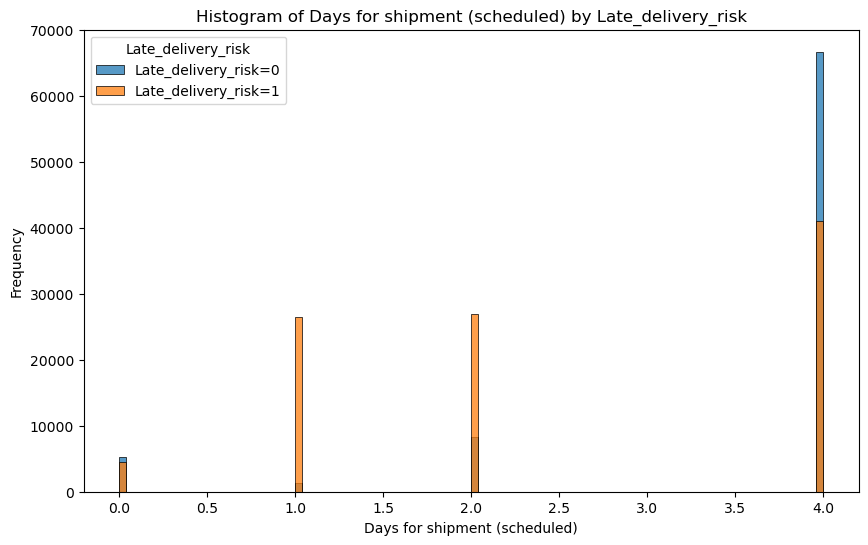

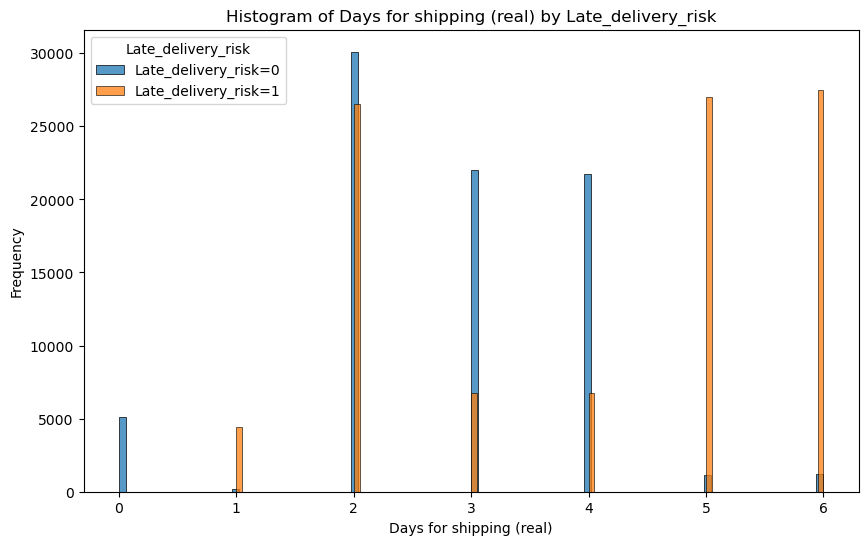

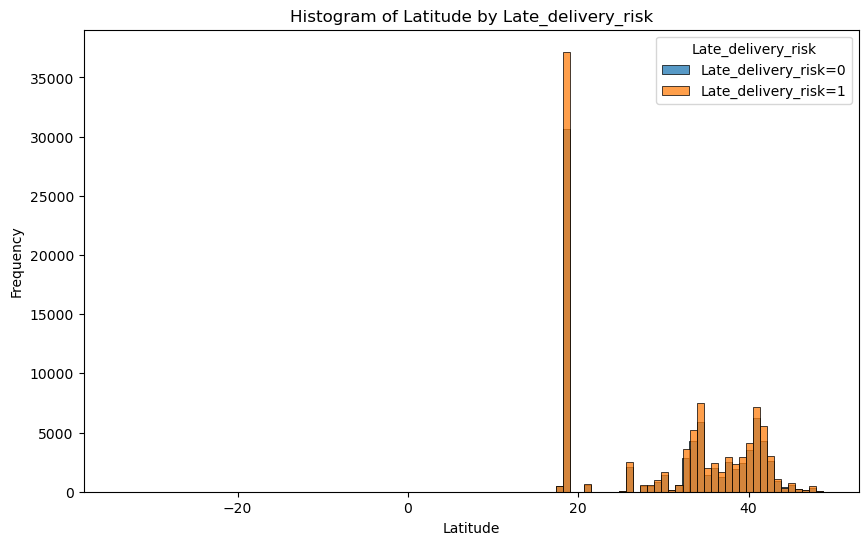

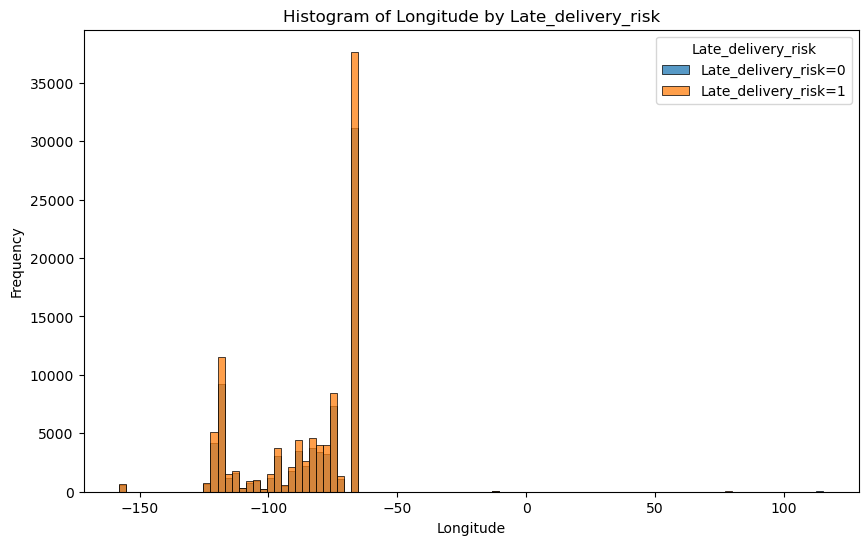

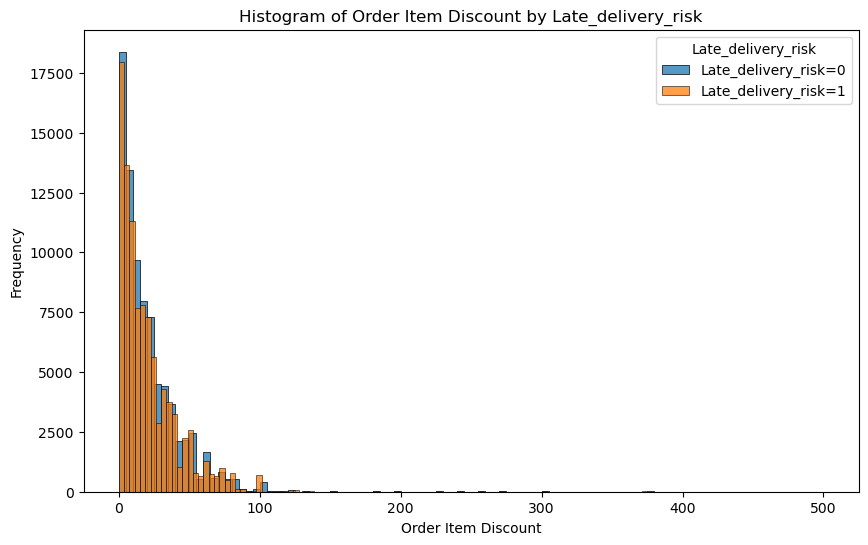

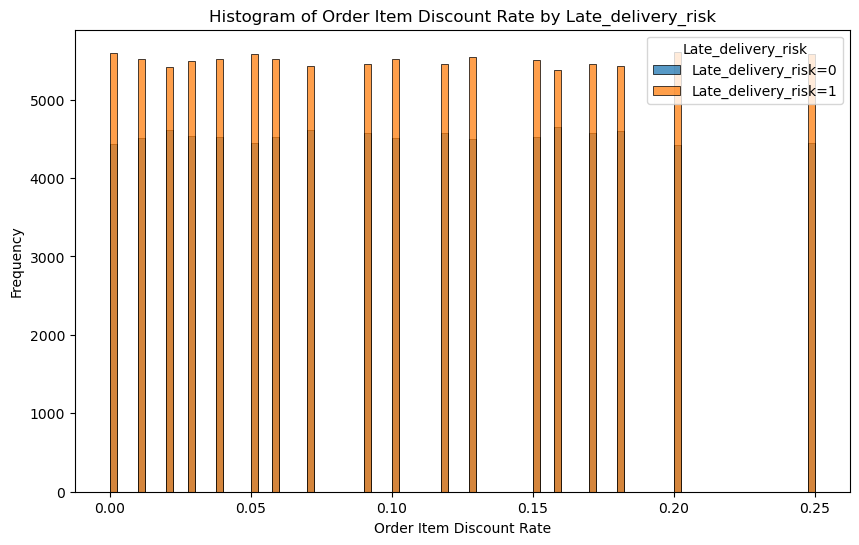

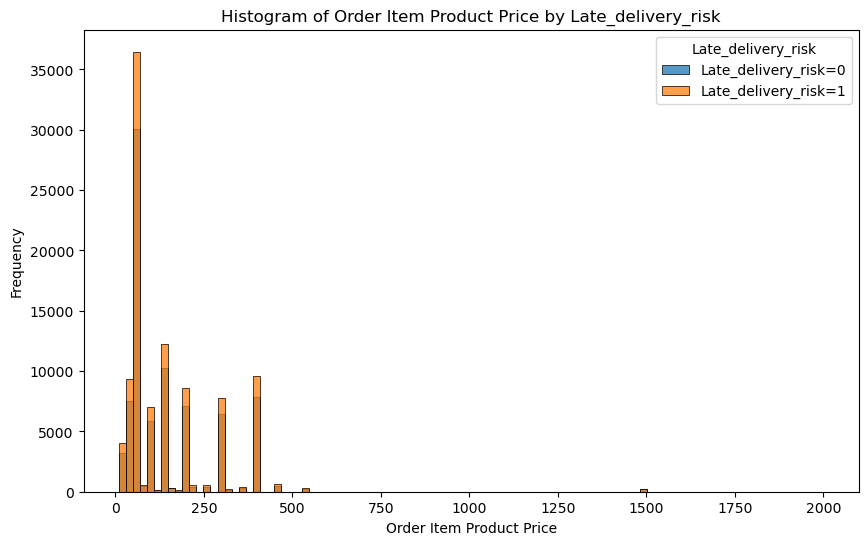

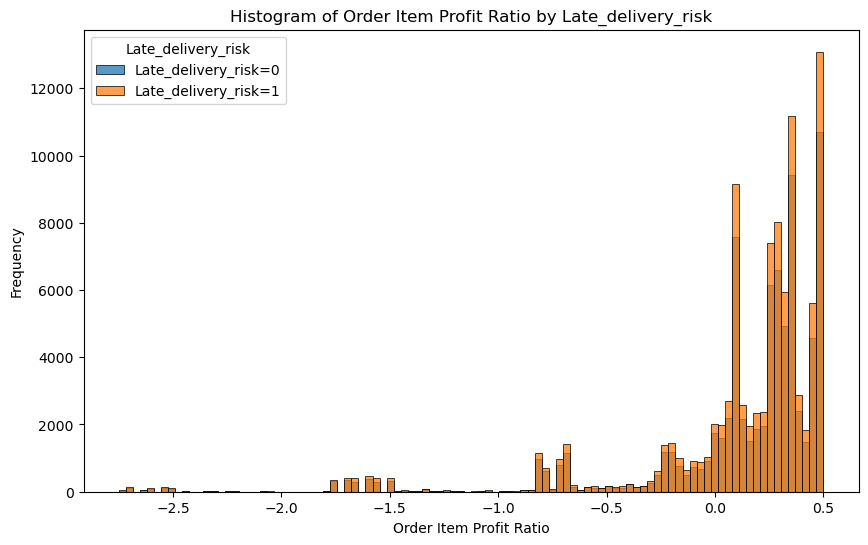

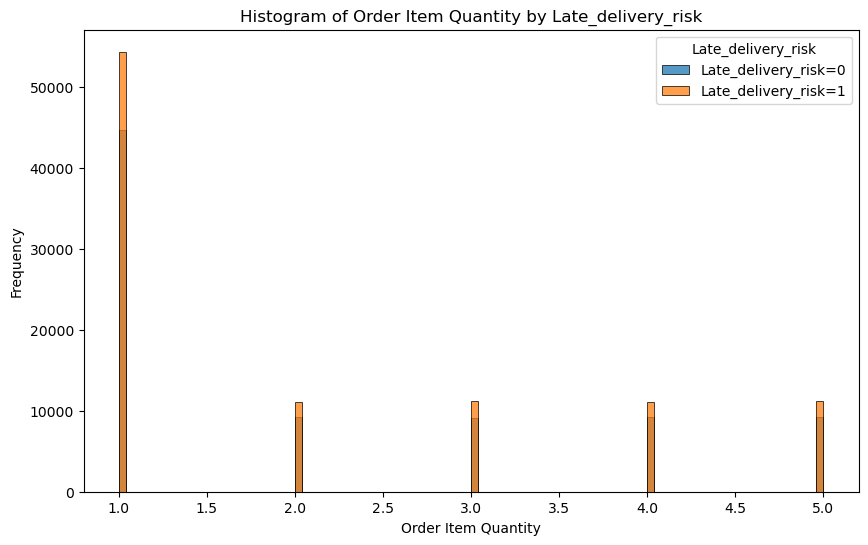

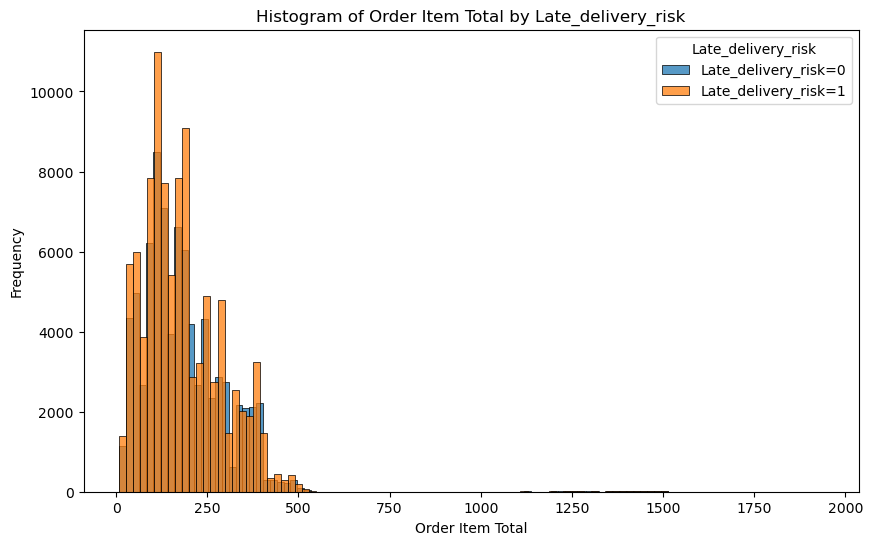

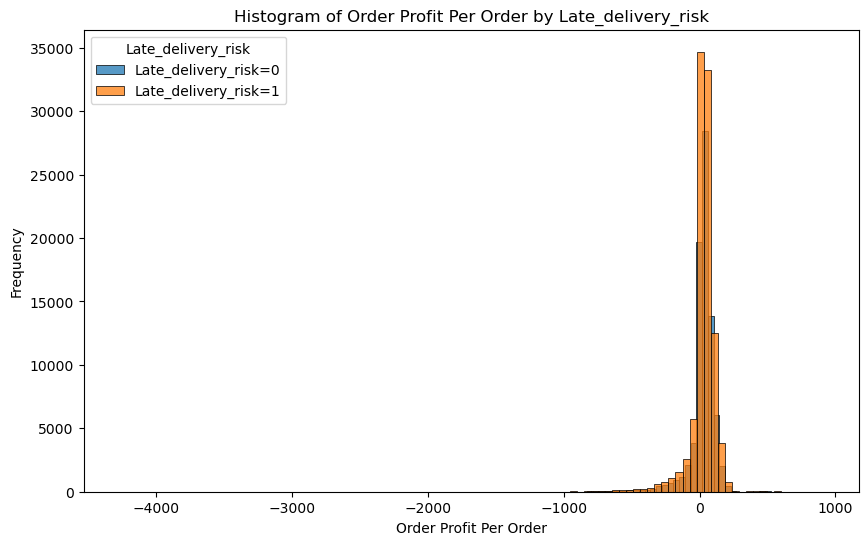

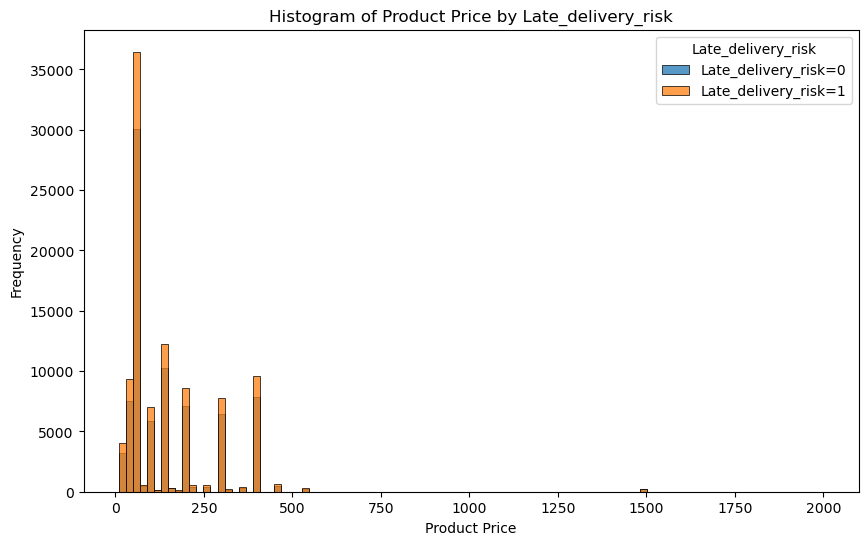

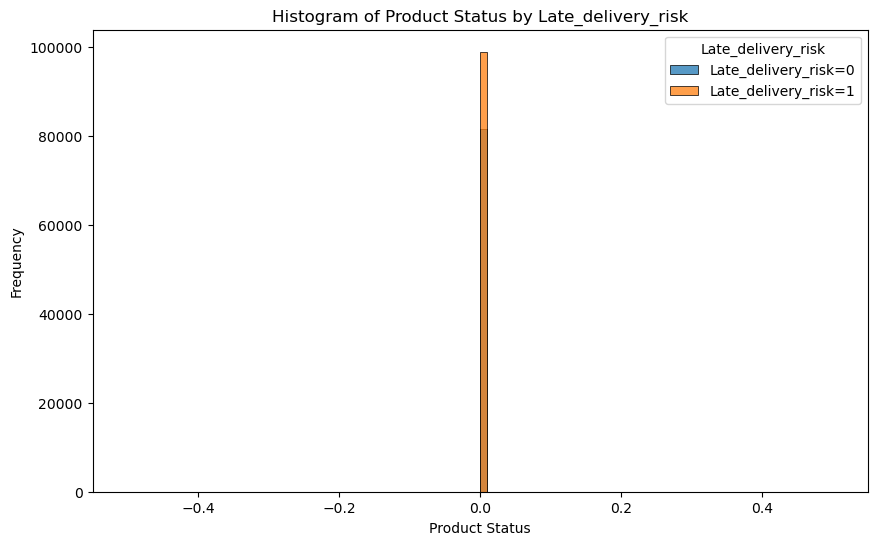

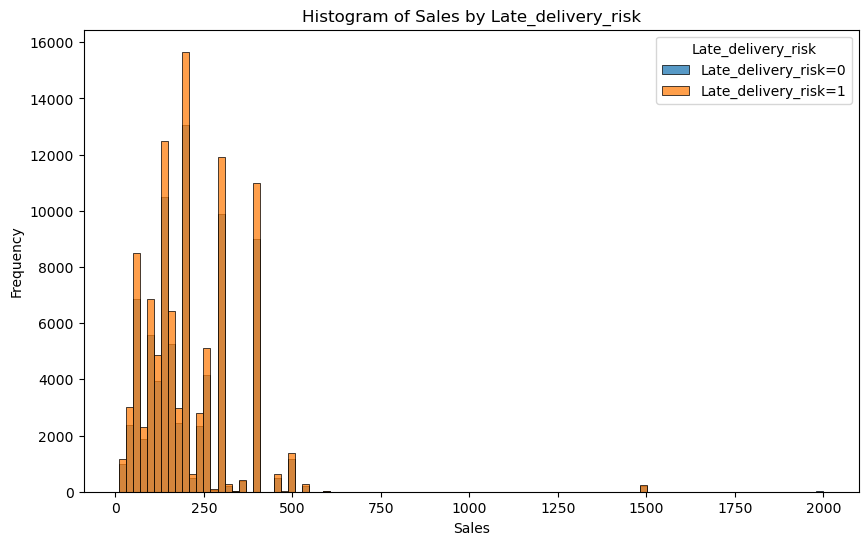

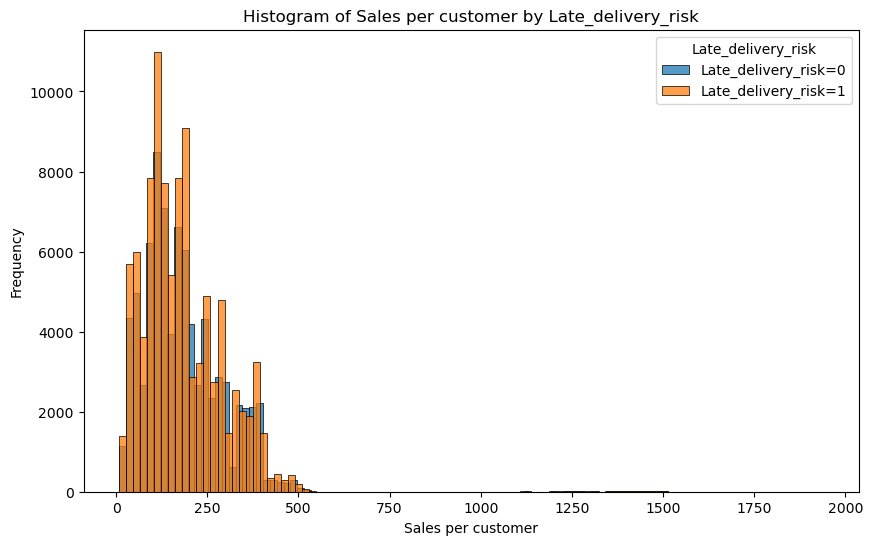

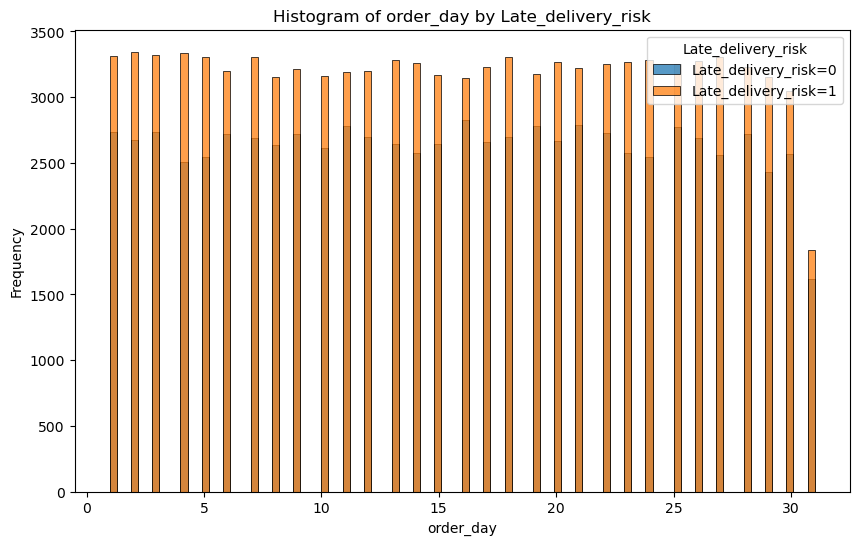

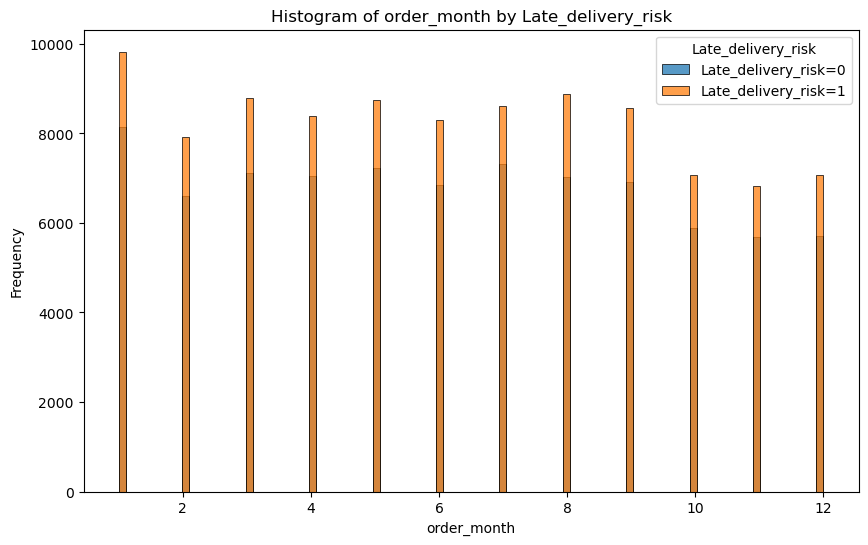

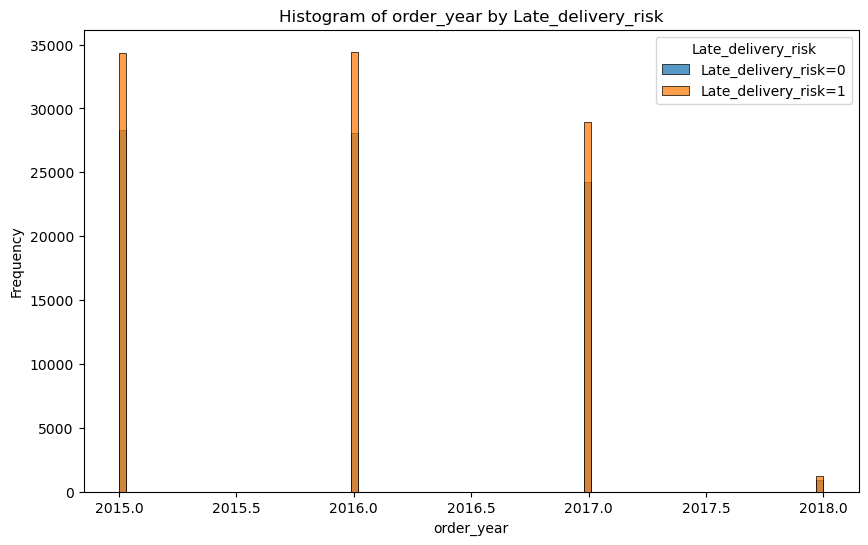

In [12]:
numerical_columns = numerical_columns = data.select_dtypes(include=['number']).columns.difference(['Late_delivery_risk'])
print(numerical_columns)

target = 'Late_delivery_risk'

# Drop the columns that are not useful for the model
numerical_columns = numerical_columns.drop([
    'Category Id', 'Customer Id', 'Customer Zipcode', 'Department Id', 'Order Customer Id',
    'Order Id', 'Order Item Cardprod Id', 'Order Item Id', 'Order Zipcode', 'Product Card Id',
    'Product Category Id', 'Product Description'
])

for col in numerical_columns:
    plt.figure(figsize=(10, 6))
    
    # Plot histogram for each target value
    for value in data[target].unique():
        sns.histplot(data[data[target] == value][col], label=f'{target}={value}', kde=False, bins=100)
    
    plt.title(f'Histogram of {col} by {target}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.legend(title=target)
    plt.show()

In [13]:
columns_to_analyze

{'Type': ['CASH', 'DEBIT', 'PAYMENT', 'TRANSFER'],
 'Customer Country': ['EE. UU.', 'Puerto Rico'],
 'Customer Segment': ['Consumer', 'Corporate', 'Home Office'],
 'Customer State': ['91732'],
 'Market': ['Africa', 'Europe', 'LATAM', 'Pacific Asia', 'USCA'],
 'Order Country': ['Armenia',
  'Baréin',
  'Burkina Faso',
  'Burundi',
  'Bután',
  'Chad',
  'Eritrea',
  'Eslovenia',
  'Estonia',
  'Gabón',
  'Guayana Francesa',
  'Guinea Ecuatorial',
  'Guyana',
  'Kuwait',
  'Laos',
  'Luxemburgo',
  'Líbano',
  'Macedonia',
  'Namibia',
  'Omán',
  'República de Gambia',
  'República del Congo',
  'Serbia',
  'Suazilandia',
  'Sudán del Sur',
  'Surinam',
  'Sáhara Occidental',
  'Taiwán',
  'Túnez']}

In [14]:
# Note that we don't take shipping date into account because it is not available at the time of prediction (shipping date - order date = days for shipping)
new_dataset_features = ['Type', 'Late_delivery_risk','Benefit per order', 'Days for shipping (real)',
                        'Latitude','Longitude','Shipping Mode','Order Status',
                        'Order Country', 'order_day','order_month','order_year','Category Name',
                        'Product Name', 'Order Id', 'Customer State', 'Market', 'Customer Segment', 'Department Name', ]
len(new_dataset_features)

19

In [15]:
new_data = data[new_dataset_features]
statuses_to_drop = ['CANCELED', 'SUSPECTED_FRAUD']
# Drop rows where late delivery risk is always 0 (when the order status is 'CANCELED' or 'SUSPECTED_FRAUD')
model_data = new_data[~new_data['Order Status'].isin(statuses_to_drop)]
# Drop rows where 'Order Status' is in the list of statuses to drop
model_data.head()

,Type,Late_delivery_risk,Benefit per order,Days for shipping (real),Latitude,Longitude,Shipping Mode,Order Status,Order Country,order_day,order_month,order_year,Category Name,Product Name,Order Id,Customer State,Market,Customer Segment,Department Name
0,DEBIT,0,91.250000,3,18.251453,-66.037056,Standard Class,COMPLETE,Indonesia,31,1,2018,Sporting Goods,Smart watch,77202,PR,Pacific Asia,Consumer,Fitness
1,TRANSFER,1,-249.089996,5,18.279451,-66.037064,Standard Class,PENDING,India,13,1,2018,Sporting Goods,Smart watch,75939,PR,Pacific Asia,Consumer,Fitness
2,CASH,0,-247.779999,4,37.292233,-121.881279,Standard Class,CLOSED,India,13,1,2018,Sporting Goods,Smart watch,75938,CA,Pacific Asia,Consumer,Fitness
3,DEBIT,0,22.860001,3,34.125946,-118.291016,Standard Class,COMPLETE,Australia,13,1,2018,Sporting Goods,Smart watch,75937,CA,Pacific Asia,Home Office,Fitness
4,PAYMENT,0,134.210007,2,18.253769,-66.037048,Standard Class,PENDING_PAYMENT,Australia,13,1,2018,Sporting Goods,Smart watch,75936,PR,Pacific Asia,Corporate,Fitness


In [16]:
#One-Hot encoding categotical variables in the data
model_data = pd.get_dummies(model_data)
model_data.shape
model_data

,Late_delivery_risk,Benefit per order,Days for shipping (real),Latitude,Longitude,order_day,order_month,order_year,Order Id,Type_CASH,Type_DEBIT,Type_PAYMENT,Type_TRANSFER,Shipping Mode_First Class,Shipping Mode_Same Day,Shipping Mode_Second Class,Shipping Mode_Standard Class,Order Status_CLOSED,Order Status_COMPLETE,Order Status_ON_HOLD,Order Status_PAYMENT_REVIEW,Order Status_PENDING,Order Status_PENDING_PAYMENT,Order Status_PROCESSING,Order Country_Afganistán,Order Country_Albania,Order Country_Alemania,Order Country_Angola,Order Country_Arabia Saudí,Order Country_Argelia,Order Country_Argentina,Order Country_Armenia,Order Country_Australia,Order Country_Austria,Order Country_Azerbaiyán,Order Country_Bangladés,Order Country_Barbados,Order Country_Baréin,Order Country_Belice,Order Country_Benín,Order Country_Bielorrusia,Order Country_Bolivia,Order Country_Bosnia y Herzegovina,Order Country_Botsuana,Order Country_Brasil,Order Country_Bulgaria,Order Country_Burkina Faso,Order Country_Burundi,Order Country_Bután,Order Country_Bélgica,Order Country_Camboya,Order Country_Camerún,Order Country_Canada,Order Country_Chad,Order Country_Chile,Order Country_China,Order Country_Chipre,Order Country_Colombia,Order Country_Corea del Sur,Order Country_Costa Rica,Order Country_Costa de Marfil,Order Country_Croacia,Order Country_Cuba,Order Country_Dinamarca,Order Country_Ecuador,Order Country_Egipto,Order Country_El Salvador,Order Country_Emiratos Árabes Unidos,Order Country_Eritrea,Order Country_Eslovaquia,Order Country_Eslovenia,Order Country_España,Order Country_Estados Unidos,Order Country_Estonia,Order Country_Etiopía,Order Country_Filipinas,Order Country_Finlandia,Order Country_Francia,Order Country_Gabón,Order Country_Georgia,Order Country_Ghana,Order Country_Grecia,Order Country_Guadalupe,Order Country_Guatemala,Order Country_Guayana Francesa,Order Country_Guinea,Order Country_Guinea Ecuatorial,Order Country_Guinea-Bissau,Order Country_Guyana,Order Country_Haití,Order Country_Honduras,Order Country_Hong Kong,Order Country_Hungría,Order Country_India,Order Country_Indonesia,Order Country_Irak,Order Country_Irlanda,Order Country_Irán,Order Country_Israel,Order Country_Italia,Order Country_Jamaica,Order Country_Japón,Order Country_Jordania,Order Country_Kazajistán,Order Country_Kenia,Order Country_Kirguistán,Order Country_Kuwait,Order Country_Laos,Order Country_Lesoto,Order Country_Liberia,Order Country_Libia,Order Country_Lituania,Order Country_Luxemburgo,Order Country_Líbano,Order Country_Macedonia,Order Country_Madagascar,Order Country_Malasia,Order Country_Mali,Order Country_Marruecos,Order Country_Martinica,Order Country_Mauritania,Order Country_Moldavia,Order Country_Mongolia,Order Country_Montenegro,Order Country_Mozambique,Order Country_Myanmar (Birmania),Order Country_México,Order Country_Namibia,Order Country_Nepal,Order Country_Nicaragua,Order Country_Nigeria,Order Country_Noruega,Order Country_Nueva Zelanda,Order Country_Níger,Order Country_Omán,Order Country_Pakistán,Order Country_Panamá,Order Country_Papúa Nueva Guinea,Order Country_Paraguay,Order Country_Países Bajos,Order Country_Perú,Order Country_Polonia,Order Country_Portugal,Order Country_Qatar,Order Country_Reino Unido,Order Country_República Centroafricana,Order Country_República Checa,Order Country_República Democrática del Congo,Order Country_República Dominicana,Order Country_República de Gambia,Order Country_República del Congo,Order Country_Ruanda,Order Country_Rumania,Order Country_Rusia,Order Country_Senegal,Order Country_Serbia,Order Country_Sierra Leona,Order Country_Singapur,Order Country_Siria,Order Country_Somalia,Order Country_Sri Lanka,Order Country_Suazilandia,Order Country_SudAfrica,Order Country_Sudán,Order Country_Sudán del Sur,Order Country_Suecia,Order Country_Suiza,Order Country_Surinam,Order Country_Sáhara Occidental,Order Country_Tailandia,Order Country_Taiwán,Order Country_Tanzania,Order Country_Tayikistán,Order Country_Togo,Order Country_Tr

In [17]:
# Drop the one-hot encoded columns that do not have a significant difference in late delivery risk
for col in columns_to_analyze:
    # Get all columns that are one-hot encoded from the original column
    one_hot_encoded_columns = [c for c in model_data.columns if c.startswith(col)]
    # Make a list with the columns that should be kept
    columns_to_keep = [c for c in one_hot_encoded_columns if c.split('_')[-1] in columns_to_analyze[col]]
    # Drop the columns that are not in the list of values to analyze
    columns_to_drop = list(set(one_hot_encoded_columns) - set(columns_to_keep))
    model_data = model_data.drop(columns=columns_to_drop)
model_data

,Late_delivery_risk,Benefit per order,Days for shipping (real),Latitude,Longitude,order_day,order_month,order_year,Order Id,Type_CASH,Type_DEBIT,Type_PAYMENT,Type_TRANSFER,Shipping Mode_First Class,Shipping Mode_Same Day,Shipping Mode_Second Class,Shipping Mode_Standard Class,Order Status_CLOSED,Order Status_COMPLETE,Order Status_ON_HOLD,Order Status_PAYMENT_REVIEW,Order Status_PENDING,Order Status_PENDING_PAYMENT,Order Status_PROCESSING,Order Country_Armenia,Order Country_Baréin,Order Country_Burkina Faso,Order Country_Burundi,Order Country_Bután,Order Country_Chad,Order Country_Eritrea,Order Country_Eslovenia,Order Country_Estonia,Order Country_Gabón,Order Country_Guayana Francesa,Order Country_Guinea Ecuatorial,Order Country_Guyana,Order Country_Kuwait,Order Country_Laos,Order Country_Luxemburgo,Order Country_Líbano,Order Country_Macedonia,Order Country_Namibia,Order Country_Omán,Order Country_República de Gambia,Order Country_República del Congo,Order Country_Serbia,Order Country_Suazilandia,Order Country_Sudán del Sur,Order Country_Surinam,Order Country_Sáhara Occidental,Order Country_Taiwán,Order Country_Túnez,Category Name_Accessories,Category Name_As Seen on TV!,Category Name_Baby,Category Name_Baseball & Softball,Category Name_Basketball,Category Name_Books,Category Name_Boxing & MMA,Category Name_CDs,Category Name_Cameras,Category Name_Camping & Hiking,Category Name_Cardio Equipment,Category Name_Children's Clothing,Category Name_Cleats,Category Name_Computers,Category Name_Consumer Electronics,Category Name_Crafts,Category Name_DVDs,Category Name_Electronics,Category Name_Fishing,Category Name_Fitness Accessories,Category Name_Garden,Category Name_Girls' Apparel,Category Name_Golf Apparel,Category Name_Golf Bags & Carts,Category Name_Golf Balls,Category Name_Golf Gloves,Category Name_Golf Shoes,Category Name_Health and Beauty,Category Name_Hockey,Category Name_Hunting & Shooting,Category Name_Indoor/Outdoor Games,Category Name_Kids' Golf Clubs,Category Name_Lacrosse,Category Name_Men's Clothing,Category Name_Men's Footwear,Category Name_Men's Golf Clubs,Category Name_Music,Category Name_Pet Supplies,Category Name_Shop By Sport,Category Name_Soccer,Category Name_Sporting Goods,Category Name_Strength Training,Category Name_Tennis & Racquet,Category Name_Toys,Category Name_Trade-In,Category Name_Video Games,Category Name_Water Sports,Category Name_Women's Apparel,Category Name_Women's Clothing,Category Name_Women's Golf Clubs,Product Name_Adult dog supplies,Product Name_Baby sweater,Product Name_Bag Boy Beverage Holder,Product Name_Bag Boy M330 Push Cart,Product Name_Bowflex SelectTech 1090 Dumbbells,Product Name_Bridgestone e6 Straight Distance NFL Carolina,Product Name_Bridgestone e6 Straight Distance NFL San Dieg,Product Name_Bridgestone e6 Straight Distance NFL Tennesse,Product Name_Brooks Women's Ghost 6 Running Shoe,Product Name_Bushnell Pro X7 Jolt Slope Rangefinder,Product Name_CDs of rock,Product Name_Children's heaters,Product Name_Cleveland Golf Collegiate My Custom Wedge 588,Product Name_Cleveland Golf Women's 588 RTX CB Satin Chrom,Product Name_Clicgear 8.0 Shoe Brush,Product Name_Clicgear Rovic Cooler Bag,Product Name_Columbia Men's PFG Anchor Tough T-Shirt,Product Name_DVDs,Product Name_Dell Laptop,Product Name_Diamondback Boys' Insight 24 Performance Hybr,Product Name_Diamondback Girls' Clarity 24 Hybrid Bike 201,Product Name_Diamondback Women's Serene Classic Comfort Bi,Product Name_ENO Atlas Hammock Straps,Product Name_Elevation Training Mask 2.0,Product Name_Field & Stream Sportsman 16 Gun Fire Safe,Product Name_Fighting video games,Product Name_First aid kit,Product Name_Fitbit The One Wireless Activity & Sleep Trac,Product Name_Garmin Approach S3 Golf GPS Watch,Product Name_Garmin Approach S4 Golf GPS Watch,Product Name_Garmin Forerunner 910XT GPS Watch,Product Name_Glove It Imperial Golf Towel,Product Name_Glove It Urban Brick Golf Towel,Product Name_Glove It Women's Imperial Golf Glove,Product Na

In [18]:
# Make one row per order, with a column for each product and the profit for that product (instead of multiple rows per order, split by product)

product_columns = [col for col in model_data.columns if col.startswith('Product Name_')]
unpivot_columns = product_columns
# Melt the dataframe to long format, excluding profit from id_vars
df_melted = model_data.melt(id_vars=['Order Id', 'Benefit per order'], value_vars=unpivot_columns,var_name='Product', value_name='is_in_order')
# Filter out rows where the product is not in the order
df_filtered = df_melted[df_melted['is_in_order'] == True]
# # Create a profit column for each product
df_filtered['Product'] = df_filtered['Product'].str.replace('Product Name_', 'Profit on ')
# # Pivot the dataframe to get the desired format
df_pivot = df_filtered.pivot_table(index='Order Id', columns='Product', values='Benefit per order', aggfunc='first')
# # Reset index to turn order_id back into a column
result_df = df_pivot.reset_index()
# # Fill NaN values with 0 (optional, if you prefer to have 0 instead of NaN)
result_df = result_df.fillna(0)
# # Drop column "Product Name" and "Benefit per order"
columns_to_drop = list(model_data.filter(like='Product Name_').columns) + ['Benefit per order']
df_cleaned = model_data.drop(columns=columns_to_drop)
# # Grab the first row for each order_id
df1_first_row = df_cleaned.groupby('Order Id').head(1)
# # Merge the two dataframes
result = pd.merge(df1_first_row, result_df, on='Order Id', how='left')
result = result.fillna(0)
# # Drop the 'Order Id' column
prep_data = result.drop(columns=['Order Id'])
prep_data

,Late_delivery_risk,Days for shipping (real),Latitude,Longitude,order_day,order_month,order_year,Type_CASH,Type_DEBIT,Type_PAYMENT,Type_TRANSFER,Shipping Mode_First Class,Shipping Mode_Same Day,Shipping Mode_Second Class,Shipping Mode_Standard Class,Order Status_CLOSED,Order Status_COMPLETE,Order Status_ON_HOLD,Order Status_PAYMENT_REVIEW,Order Status_PENDING,Order Status_PENDING_PAYMENT,Order Status_PROCESSING,Order Country_Armenia,Order Country_Baréin,Order Country_Burkina Faso,Order Country_Burundi,Order Country_Bután,Order Country_Chad,Order Country_Eritrea,Order Country_Eslovenia,Order Country_Estonia,Order Country_Gabón,Order Country_Guayana Francesa,Order Country_Guinea Ecuatorial,Order Country_Guyana,Order Country_Kuwait,Order Country_Laos,Order Country_Luxemburgo,Order Country_Líbano,Order Country_Macedonia,Order Country_Namibia,Order Country_Omán,Order Country_República de Gambia,Order Country_República del Congo,Order Country_Serbia,Order Country_Suazilandia,Order Country_Sudán del Sur,Order Country_Surinam,Order Country_Sáhara Occidental,Order Country_Taiwán,Order Country_Túnez,Category Name_Accessories,Category Name_As Seen on TV!,Category Name_Baby,Category Name_Baseball & Softball,Category Name_Basketball,Category Name_Books,Category Name_Boxing & MMA,Category Name_CDs,Category Name_Cameras,Category Name_Camping & Hiking,Category Name_Cardio Equipment,Category Name_Children's Clothing,Category Name_Cleats,Category Name_Computers,Category Name_Consumer Electronics,Category Name_Crafts,Category Name_DVDs,Category Name_Electronics,Category Name_Fishing,Category Name_Fitness Accessories,Category Name_Garden,Category Name_Girls' Apparel,Category Name_Golf Apparel,Category Name_Golf Bags & Carts,Category Name_Golf Balls,Category Name_Golf Gloves,Category Name_Golf Shoes,Category Name_Health and Beauty,Category Name_Hockey,Category Name_Hunting & Shooting,Category Name_Indoor/Outdoor Games,Category Name_Kids' Golf Clubs,Category Name_Lacrosse,Category Name_Men's Clothing,Category Name_Men's Footwear,Category Name_Men's Golf Clubs,Category Name_Music,Category Name_Pet Supplies,Category Name_Shop By Sport,Category Name_Soccer,Category Name_Sporting Goods,Category Name_Strength Training,Category Name_Tennis & Racquet,Category Name_Toys,Category Name_Trade-In,Category Name_Video Games,Category Name_Water Sports,Category Name_Women's Apparel,Category Name_Women's Clothing,Category Name_Women's Golf Clubs,Customer State_91732,Market_Africa,Market_Europe,Market_LATAM,Market_Pacific Asia,Market_USCA,Customer Segment_Consumer,Customer Segment_Corporate,Customer Segment_Home Office,Department Name_Apparel,Department Name_Book Shop,Department Name_Discs Shop,Department Name_Fan Shop,Department Name_Fitness,Department Name_Footwear,Department Name_Golf,Department Name_Health and Beauty,Department Name_Outdoors,Department Name_Pet Shop,Department Name_Technology,Profit on Adult dog supplies,Profit on Baby sweater,Profit on Bag Boy Beverage Holder,Profit on Bag Boy M330 Push Cart,Profit on Bowflex SelectTech 1090 Dumbbells,Profit on Bridgestone e6 Straight Distance NFL Carolina,Profit on Bridgestone e6 Straight Distance NFL San Dieg,Profit on Bridgestone e6 Straight Distance NFL Tennesse,Profit on Brooks Women's Ghost 6 Running Shoe,Profit on Bushnell Pro X7 Jolt Slope Rangefinder,Profit on CDs of rock,Profit on Children's heaters,Profit on Cleveland Golf Collegiate My Custom Wedge 588,Profit on Cleveland Golf Women's 588 RTX CB Satin Chrom,Profit on Clicgear 8.0 Shoe Brush,Profit on Clicgear Rovic Cooler Bag,Profit on Columbia Men's PFG Anchor Tough T-Shirt,Profit on DVDs,Profit on Dell Laptop,Profit on Diamondback Boys' Insight 24 Performance Hybr,Profit on Diamondback Girls' Clarity 24 Hybrid Bike 201,Profit on Diamondback Women's Serene Classic Comfort Bi,Profit on ENO Atlas Hammock Straps,Profit on Elevation Training Mask 2.0,Profit on Field & Stream Sportsman 16 Gun Fire Safe,Profit on Fighting video games,Profit on First aid 

# 5) Classification

In [19]:
x_class = prep_data.drop(['Late_delivery_risk', 'Days for shipping (real)'],axis=1)
y_class = prep_data[['Late_delivery_risk']]
# train-test_split
x_train_class,x_test_class,y_train_class,y_test_class = model_selection.train_test_split(x_class,y_class,test_size=0.20,random_state=42,stratify=y_class)

dt_classifier_pipeline trained
lr_classifier_pipeline trained
xgb_classifier_pipeline trained
Accuracy for dt_classifier_pipeline: 0.620429252782194
ROC for dt_classifier_pipeline: 0.6113117514728406
Report for dt_classifier_pipeline:               precision    recall  f1-score   support

           0       0.56      0.55      0.55      5370
           1       0.67      0.67      0.67      7210

    accuracy                           0.62     12580
   macro avg       0.61      0.61      0.61     12580
weighted avg       0.62      0.62      0.62     12580

Accuracy for lr_classifier_pipeline: 0.6971383147853736
ROC for lr_classifier_pipeline: 0.7213840181622359
Report for lr_classifier_pipeline:               precision    recall  f1-score   support

           0       0.60      0.89      0.71      5370
           1       0.87      0.56      0.68      7210

    accuracy                           0.70     12580
   macro avg       0.73      0.72      0.70     12580
weighted avg       0.75 

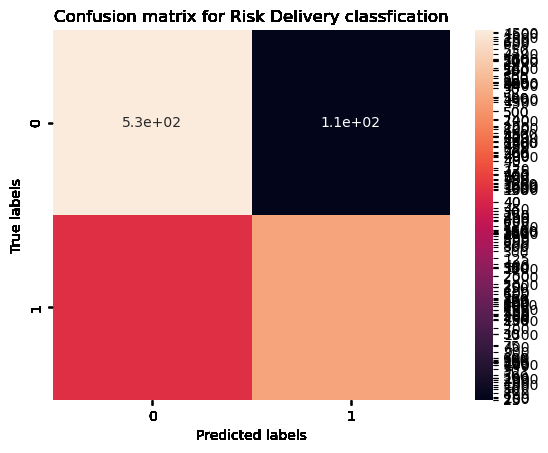

In [20]:
# Initialize models
models = model_utils.init_models(type='classification')
# Train models
model_utils.train_models(models, x_train_class, y_train_class)
# Evaluate models
preds = model_utils.predict(models, x_test_class)
acc,roc,rep = model_utils.eval_classification(y_true=y_test_class,preds=preds)
# Evaluate per order status
acc,roc,rep = model_utils.eval_per_order_status(x=x_test_class,y=y_test_class,models=models, type='classification')

# 5) Classification only important features

In [21]:
importance_df = model_utils.get_ft_importance(x=x_train_class,model=models["xgb_classifier_pipeline"], type='classification')
importance_df

,Feature,Importance
12,Shipping Mode_Standard Class,0.381377
10,Shipping Mode_Same Day,0.192280
9,Shipping Mode_First Class,0.152192
11,Shipping Mode_Second Class,0.050635
54,Category Name_Books,0.004297
...,...,...
97,Category Name_Women's Clothing,0.000000
99,Customer State_91732,0.000000
36,Order Country_Líbano,0.000000
35,Order Country_Luxemburgo,0.000000


In [22]:
# Let's drop Order City, Order Country, and Order Region as they have minimal importance compared to their dimensionality
features = ['^Market','^Type','^Latitude','^Longitude','^Order Status','^order_','^Profit on', '^Order Country']
# features = ['^Type','^Latitude','^Longitude','^Order Status','^order_','^Profit on', '^Order Country', '^Deparment Name', '^Customer Segment', '^Customer State', '^Market', '^Category Name']
# These are the features we will drop/keep depending on the performance of the model. We will definitely keep Shipping Mode, as it has the highest importance score
features_to_drop = ['^Order City_', '^Order Country_', '^Order Region_']
# features_to_drop = ['^none']
ft_performace_dict = model_utils.get_best_fts(models=models,prep_data=prep_data,features=features, features_to_drop=features_to_drop, type='classification')
ft_performace_dict

Model: dt_classifier_pipeline
Combination: ('^Type',)


KeyboardInterrupt: 

Best feature combination (as in best performing + most simple): Shipping Mode, Order Status (Order Status can also be dropped, but let's keep it for explanatory reasons, also the performance is not influenced that much by adding/dropping it)

In [51]:
features_to_drop = ['^Market','^Type','^Latitude','^Longitude','^order_','^Profit on','^Order City_', '^Order Country_', '^Order Region_']
simple_prep_data = prep_data.drop(prep_data.filter(regex='|'.join(features_to_drop)).columns, axis=1)
x_class = simple_prep_data.drop(['Late_delivery_risk', 'Days for shipping (real)'],axis=1)
y_class = simple_prep_data[['Late_delivery_risk']]
# train-test_split
x_train_class,x_test_class,y_train_class,y_test_class = model_selection.train_test_split(x_class,y_class,test_size=0.20,random_state=42,stratify=y_class)
# train-validation split
x_train_class,x_val_class,y_train_class,y_val_class = model_selection.train_test_split(x_train_class,y_train_class,test_size=0.25,random_state=42,stratify=y_train_class)

dt_classifier_pipeline trained
lr_classifier_pipeline trained
xgb_classifier_pipeline trained
Accuracy for dt_classifier_pipeline: 0.7018282988871224
ROC for dt_classifier_pipeline: 0.7264533116547528
Report for dt_classifier_pipeline:               precision    recall  f1-score   support

           0       0.60      0.91      0.72      5437
           1       0.89      0.54      0.67      7143

    accuracy                           0.70     12580
   macro avg       0.74      0.73      0.70     12580
weighted avg       0.76      0.70      0.70     12580

Accuracy for lr_classifier_pipeline: 0.7018282988871224
ROC for lr_classifier_pipeline: 0.7264533116547528
Report for lr_classifier_pipeline:               precision    recall  f1-score   support

           0       0.60      0.91      0.72      5437
           1       0.89      0.54      0.67      7143

    accuracy                           0.70     12580
   macro avg       0.74      0.73      0.70     12580
weighted avg       0.76

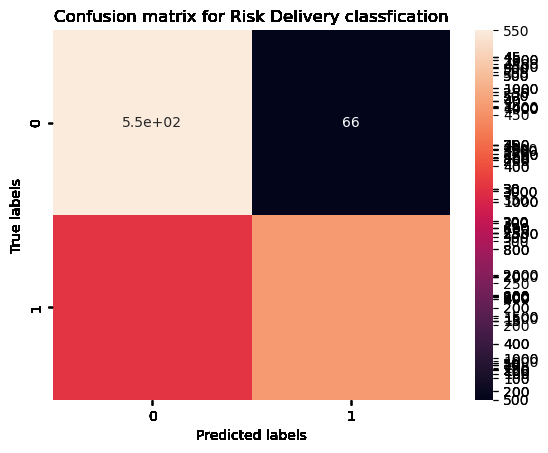

In [52]:
# Initialize models
models = model_utils.init_models(type='classification')
# Train models
model_utils.train_models(models, x_train_class, y_train_class)
# Evaluate models
preds = model_utils.predict(models, x_test_class)
acc,roc,rep = model_utils.eval_classification(y_true=y_test_class,preds=preds)
# Evaluate per order status
acc,roc,rep = model_utils.eval_per_order_status(x=x_test_class,y=y_test_class,models=models, type='classification')

Let's also try a Neural Network using all features (except for City, Country, Region...)

In [82]:
# features_to_drop = ['^Order City_', '^Order Country_', '^Order Region_', '^Profit on']
features_to_drop = ['^Order City_', '^Order Country_', '^Order Region_', '^Profit on', '^Market','^Type','^Latitude','^Longitude','^order_']
# features_to_drop = ['^none']
simple_prep_data = prep_data.drop(prep_data.filter(regex='|'.join(features_to_drop)).columns, axis=1)
x_class = simple_prep_data.drop(['Late_delivery_risk', 'Days for shipping (real)'],axis=1)
y_class = simple_prep_data[['Late_delivery_risk']]
# train-test_split
x_train_class,x_test_class,y_train_class,y_test_class = model_selection.train_test_split(x_class,y_class,test_size=0.20,random_state=42,stratify=y_class)
# train-validation split
x_train_class,x_val_class,y_train_class,y_val_class = model_selection.train_test_split(x_train_class,y_train_class,test_size=0.25,random_state=42,stratify=y_train_class)

mlp_classifier_pipeline trained


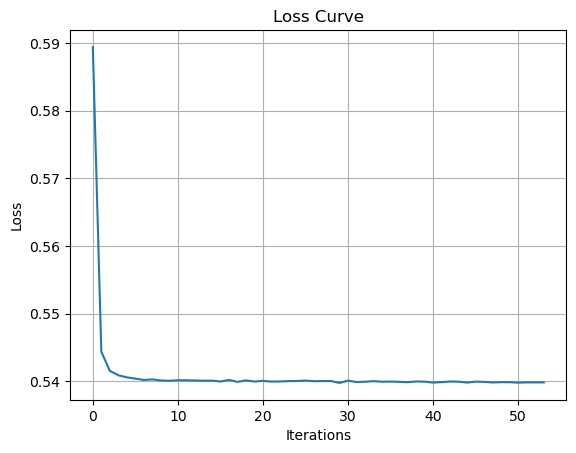

Accuracy for mlp_classifier_pipeline: 0.6966613672496026
ROC for mlp_classifier_pipeline: 0.7179026646727465
Report for mlp_classifier_pipeline:               precision    recall  f1-score   support

           0       0.60      0.86      0.71      5370
           1       0.85      0.57      0.68      7210

    accuracy                           0.70     12580
   macro avg       0.72      0.72      0.70     12580
weighted avg       0.74      0.70      0.69     12580

Order Status: PENDING


EVALUATION OF mlp_classifier_pipeline
Accuracy for mlp_classifier_pipeline: 0.6986486486486486
ROC for mlp_classifier_pipeline: 0.7155155132859656
Report for mlp_classifier_pipeline:               precision    recall  f1-score   support

           0       0.61      0.85      0.71       646
           1       0.83      0.58      0.69       834

    accuracy                           0.70      1480
   macro avg       0.72      0.72      0.70      1480
weighted avg       0.74      0.70      0.70      

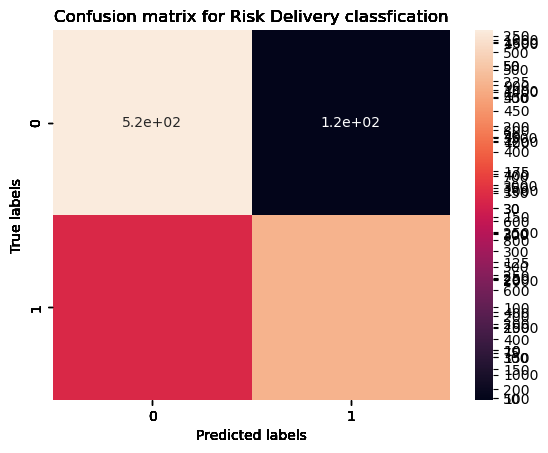

In [83]:
# Initialize models
nn_models = model_utils.init_nn(type='classification')
# Train models
model_utils.train_models(nn_models, x_train_class, y_train_class)
# Evaluate models
preds = model_utils.predict(nn_models, x_test_class)
acc,roc,rep = model_utils.eval_classification(y_true=y_test_class,preds=preds)
# Evaluate per order status
acc,roc,rep = model_utils.eval_per_order_status(x=x_test_class,y=y_test_class,models=nn_models, type='classification')

# 6) Regression

In [15]:
x_reg = prep_data.drop(['Late_delivery_risk', 'Days for shipping (real)'],axis=1)
y_reg = prep_data[['Days for shipping (real)']]
x_train_reg,x_test_reg,y_train_reg,y_test_reg = model_selection.train_test_split(x_reg,y_reg,test_size=0.20,random_state=42,stratify=y_reg)

In [17]:
# Initialize models
models = model_utils.init_models(type='regression')
# Train models
model_utils.train_models(models, x_train_reg, y_train_reg)
# Evaluate models
preds = model_utils.predict(models, x_test_reg)
acc,roc,rep = model_utils.eval_regression(y_true=y_test_reg,preds=preds)
# Evaluate per order status
acc,roc,rep = model_utils.eval_per_order_status(x=x_test_reg,y=y_test_reg,models=models, type='regression')

dt_regressor_pipeline trained
xgb_regressor_pipeline trained
R2 for dt_regressor_pipeline: -0.2226921116300622
MSE for dt_regressor_pipeline: 3.2322734499205086
MAE for dt_regressor_pipeline: 1.2966613672496026
R2 for xgb_regressor_pipeline: 0.3769915806712896
MSE for xgb_regressor_pipeline: 1.6469670113340922
MAE for xgb_regressor_pipeline: 1.0049139448449709
Order Status: PENDING


EVALUATION OF dt_regressor_pipeline
R2 for dt_regressor_pipeline: -0.14987984114769004
MSE for dt_regressor_pipeline: 3.0520028109627546
MAE for dt_regressor_pipeline: 1.2459592410400562



Order Status: PROCESSING


EVALUATION OF dt_regressor_pipeline
R2 for dt_regressor_pipeline: -0.20967963244387744
MSE for dt_regressor_pipeline: 3.2396166134185305
MAE for dt_regressor_pipeline: 1.3124600638977635



Order Status: PENDING_PAYMENT


EVALUATION OF dt_regressor_pipeline
R2 for dt_regressor_pipeline: -0.23749021389980185
MSE for dt_regressor_pipeline: 3.2057712126417037
MAE for dt_regressor_pipeline: 1.2875

# 6) Regression only important features

In [20]:
importance_df = model_utils.get_ft_importance(x=x_train_reg,model=models["xgb_regressor_pipeline"], type='regression')
importance_df

,Feature,Importance
10,Shipping Mode_Same Day,0.330393
9,Shipping Mode_First Class,0.127403
2762,Order City_Preston,0.003903
1597,Order City_Huddersfield,0.002670
74,Order Country_China,0.002602
...,...,...
1632,Order City_Imola,0.000000
1633,Order City_Imphal,0.000000
1634,Order City_Indaial,0.000000
369,Order City_Arcoverde,0.000000


In [27]:
# Let's drop Order City, Order Country, and Order Region as they have minimal importance compared to their dimensionality
features = ['^Market','^Type','^Latitude','^Longitude','^Order Status','^order_','^Profit on']
# These are the features we will drop/keep depending on the performance of the model. We will definitely keep Shipping Mode, as it has the highest importance score
features_to_drop = ['^Order City_', '^Order Country_', '^Order Region_']
ft_performace_dict = model_utils.get_best_fts(models=models,prep_data=prep_data,features=features, features_to_drop=features_to_drop, type='regression')
ft_performace_dict

Model: dt_regressor_pipeline
Combination: ('^Market',)
Performance: 1.3085055643879173


Model: dt_regressor_pipeline
Combination: ('^Type',)
Performance: 1.2919713831478536


Model: dt_regressor_pipeline
Combination: ('^Latitude',)
Performance: 1.3027027027027027


Model: dt_regressor_pipeline
Combination: ('^Longitude',)
Performance: 1.309777424483307


Model: dt_regressor_pipeline
Combination: ('^Order Status',)
Performance: 1.295945945945946


Model: dt_regressor_pipeline
Combination: ('^order_',)
Performance: 1.3001589825119237


Model: dt_regressor_pipeline
Combination: ('^Profit on',)
Performance: 1.2941176470588236


Model: dt_regressor_pipeline
Combination: ('^Order City_',)
Performance: 1.3038950715421305


Model: dt_regressor_pipeline
Combination: ('^Order Country_',)
Performance: 1.3038950715421305


Model: dt_regressor_pipeline
Combination: ('^Order Region_',)
Performance: 1.3038950715421305


Model: dt_regressor_pipeline
Combination: ('^Market', '^Type')
Performance: 1.29

{'dt_regressor_pipeline': {('^Market',
   '^Type',
   '^Longitude',
   '^Order Status'): 1.3191573926868045,
  ('^Market',
   '^Type',
   '^Longitude',
   '^Order Status',
   '^Order City_'): 1.3191573926868045,
  ('^Market',
   '^Type',
   '^Longitude',
   '^Order Status',
   '^Order Country_'): 1.3191573926868045,
  ('^Market',
   '^Type',
   '^Longitude',
   '^Order Status',
   '^Order Region_'): 1.3191573926868045,
  ('^Market',
   '^Type',
   '^Longitude',
   '^Order Status',
   '^Order City_',
   '^Order Country_'): 1.3191573926868045,
  ('^Market',
   '^Type',
   '^Longitude',
   '^Order Status',
   '^Order City_',
   '^Order Region_'): 1.3191573926868045,
  ('^Market',
   '^Type',
   '^Longitude',
   '^Order Status',
   '^Order Country_',
   '^Order Region_'): 1.3191573926868045,
  ('^Market',
   '^Type',
   '^Longitude',
   '^Order Status',
   '^Order City_',
   '^Order Country_',
   '^Order Region_'): 1.3191573926868045,
  ('^Market', '^Type', '^Order Status'): 1.316852146263

Best feature combination (as in best performing + most simple): Shipping Mode, Order Status (Order Status can also be dropped, but let's keep it for explanatory reasons, also the performance is not influenced that much by adding/dropping it)

In [45]:
features_to_drop = ['^Market','^Type','^Latitude','^Longitude','^order_','^Profit on','^Order City_', '^Order Country_', '^Order Region_']
simple_prep_data = prep_data.drop(prep_data.filter(regex='|'.join(features_to_drop)).columns, axis=1)
x_reg = simple_prep_data.drop(['Late_delivery_risk', 'Days for shipping (real)'],axis=1)
y_reg = simple_prep_data[['Days for shipping (real)']]
# train-test_split
x_train_reg,x_test_reg,y_train_reg,y_test_reg = model_selection.train_test_split(x_reg,y_reg,test_size=0.20,random_state=42,stratify=y_reg)
# train-validation split
x_train_reg,x_val_reg,y_train_reg,y_val_reg = model_selection.train_test_split(x_train_reg,y_train_reg,test_size=0.25,random_state=42,stratify=y_train_reg)

In [46]:
# Initialize models
models = model_utils.init_models(type='regression')
# Train models
model_utils.train_models(models, x_train_reg, y_train_reg)
# Evaluate models
preds = model_utils.predict(models, x_test_reg)
acc,roc,rep = model_utils.eval_regression(y_true=y_test_reg,preds=preds)
# Evaluate per order status
acc,roc,rep = model_utils.eval_per_order_status(x=x_test_reg,y=y_test_reg,models=models, type='regression')

dt_regressor_pipeline trained
xgb_regressor_pipeline trained
R2 for dt_regressor_pipeline: 0.38289363263690357
MSE for dt_regressor_pipeline: 1.6313645177160774
MAE for dt_regressor_pipeline: 0.9914778183534655
R2 for xgb_regressor_pipeline: 0.3828975657295358
MSE for xgb_regressor_pipeline: 1.6313541203063204
MAE for xgb_regressor_pipeline: 0.991465984893717
Order Status: PENDING


EVALUATION OF dt_regressor_pipeline
R2 for dt_regressor_pipeline: 0.3913794576269941
MSE for dt_regressor_pipeline: 1.6153962698207807
MAE for dt_regressor_pipeline: 0.9909496793513317



Order Status: PROCESSING


EVALUATION OF dt_regressor_pipeline
R2 for dt_regressor_pipeline: 0.36809573562325626
MSE for dt_regressor_pipeline: 1.6922890144303473
MAE for dt_regressor_pipeline: 1.016977531128175



Order Status: PENDING_PAYMENT


EVALUATION OF dt_regressor_pipeline
R2 for dt_regressor_pipeline: 0.37389803115677456
MSE for dt_regressor_pipeline: 1.6219438710312266
MAE for dt_regressor_pipeline: 0.9915873380